# Conversational Chatbot

In this project, we handcraft a transformer model from scratch using PyTorch. Transformer model is based on the idea of 'self-attention' which allows it to extract a very rich contextual representation of the words in the sentences. Those vectorial representations are then used in different NLP tasks. Soon after the invention of the original transformer architecture, BERT and GPT models were derived from the transformer encoder or decoder for transfer learning in various NLP tasks. The original transformer containing a encoder and a decoder was for sequence-to-sequence (seq2seq) tasks like language translation. Here we apply the original transformer achitecture to build another seq2seq model, a toy conversational chatbot!

## Data preparation & preprocessing

### Import libraries

In [823]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from preprocessing import *

### Prepare the dataset

 This is the tiny toy corpus that the transformer model is going to be trained on.

In [729]:
train_raw = [
             ["Hello i am jiayu. What is your name?", "I am Dennis. Nice to meet you."],
             ["How was the party yesterday?", "It was super nice. Everybody had fun."],
             ["When do you usually go to the office in the morning", "I usually go to the office at 9 but I was late this morning."],
             ["Do you want to meet in the campus at 10 pm tonight?", "okay that sounds good. I will meet you there tonight."],
             ["Does this Sunday works for everyone?", "Yes, it works perferct for me!"],
             ["What is your favourite book of all time?", "Three body problem. I love it so much and I have read it twice!"],
             ["What do you love doing for fun at spare time?", "I play soccer and go hiking and I sometimes go swimming too."],
             ["How was the exam last week? Was it hard?", "It was quite hard actually. I didn't do it well."],
             ["Hope you could enjoy your trip next week!", "Thanks! I'm sure I will!"],
             ["Is it gonna rain later today?", "Yes I think so. Don't forget your umbrella!"],
             ["So, what are your plans for this weekend?", "I don’t know. Do you want to get together or something?"],
             ["I don’t know. Do you want to get together or something?", "How about going to see a movie?"],
             ["How about going to see a movie?", "That sounds like a good idea. Maybe we should go out to eat beforehand."],
             ["That sounds like a good idea. Maybe we should go out to eat beforehand.", "It is fine with me. Where do you want to meet?"],
             ["It is fine with me. Where do you want to meet?", "Let’s meet at Summer Pizza House. I have not gone there for a long time."],
             ["When should we meet?", "Well, the movie is shown at 2 pm. How about we meet at 1 pm?"],
             ["What is she doing these days?", "She graduated last June, and she will start her teaching career next week."],
             ["Hi, I haven't seen you in a while.", "Yes, I know it has been a long time!"],
             ["What have you been doing lately?", "I have been going to graduate school."],
             ["What are you majoring in?", "I am studying theoretical physics. It is hard!"],
             ["Okay nice to see you today! Bye!", "Yeah me too! See you later, bye!"],
]
train_raw = pd.DataFrame(train_raw)


Cleanse the data using the class 'S2STextPreprocessor' written in the file 'preprocessing.py'. 

In [730]:
print('-'*21 + '\n|Before cleansing...|\n' + '-'*21)
vocab = corpus_to_vocab(train_raw)
num_tokens_before = len(vocab)
print(f"There are {num_tokens_before} tokens")

print('-'*21 + '\n|Cleansing corpus...|\n' + '-'*21)
preprocessor = S2STextPreprocessor(to_keep = "", max_seq_length = 20)
train = preprocessor.cleanse_corpus(train_raw)

print('-'*20 + '\n|After cleansing...|\n' + '-'*20)
vocab = corpus_to_vocab(train)
num_tokens_after = len(vocab)
print(f"There are {num_tokens_after} tokens")
print(f"{100 * (num_tokens_before - num_tokens_after) / num_tokens_before:.2f}% tokens were cleansed")


---------------------
|Before cleansing...|
---------------------
There are 200 tokens
---------------------
|Cleansing corpus...|
---------------------
--------------------
|After cleansing...|
--------------------
There are 156 tokens
22.00% tokens were cleansed


In [731]:
train.head(10)

,0,1
0,hello i am jiayu what is your name,i am dennis nice to meet you
1,how was the party yesterday,it was super nice everybody had fun
2,when do you usually go to the office in the mo...,i usually go to the office at 9 but i was late...
3,do you want to meet in the campus at 10 pm ton...,okay that sounds good i will meet you there t...
4,does this sunday works for everyone,yes it works perferct for me
5,what is your favourite book of all time,three body problem i love it so much and i ha...
6,what do you love doing for fun at spare time,i play soccer and go hiking and i sometimes go...
7,how was the exam last week was it hard,it was quite hard actually i did not do it well
8,hope you could enjoy your trip next week,thanks i am sure i will
9,is it going to rain later today,yes i think so do not forget your umbrella


### Tokenization, building vocabulary and preparing the sequences

Fit the preprocessor on the cleansed corpus.

In [732]:
preprocessor.fit_on_corpus(train)

Inspect the outputs.

In [733]:
print(f"The most frequent words:\n{preprocessor.sorted_vocab[:10]}")
print("~"*100)
print("The word-to-index map:")
for word, idx in list(preprocessor.word2idx.items())[:10]:
    print(f"{word}: {idx}")
print("~"*100)


The most frequent words:
[('i', 20), ('you', 15), ('to', 15), ('it', 12), ('do', 11), ('is', 8), ('meet', 8), ('what', 7), ('the', 7), ('a', 7)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The word-to-index map:
PAD: 0
SOS: 1
EOS: 2
i: 3
you: 4
to: 5
it: 6
do: 7
is: 8
meet: 9
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Check out how many unique tokens we found in the corpus

In [824]:
# Word -> integer mapping
print('Found %i unique tokens' %len(preprocessor.word2idx))

Found 159 unique tokens


In [735]:
print(preprocessor.num_words)
print(preprocessor.max_seq_length)

156
20


## Build the model

Here we build a transformer from scratch.

### Import libraries

In [736]:
import math, copy
import torch
import torch.nn as nn

## Code up the transformer by subclassing ```nn.Module```

The MultiHeadAttention block, which is going to be used in both encoder and decoder blocks.

In [737]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_dim, num_heads):
        super().__init__()
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = emb_dim // num_heads

        # Ensure that we have exactly emb_dim = head_dim * num_heads
        assert emb_dim % num_heads == 0, "emb_dim is not divisible by num_head!"

        self.q_linear = nn.Linear(self.head_dim, self.head_dim, bias = False)
        self.k_linear = nn.Linear(self.head_dim, self.head_dim, bias = False)
        self.v_linear = nn.Linear(self.head_dim, self.head_dim, bias = False)
        self.fc_out = nn.Linear(self.emb_dim, self.emb_dim)

    def forward(self, queries, keys, values, mask = None, approach = 0):
        batch_size = queries.shape[0]
        q_len, k_len, v_len = queries.shape[1], keys.shape[1], values.shape[1]  # k_len == v_len holds true for any cases

        # Split embedding into num_heads pieces
        queries = queries.reshape(batch_size, q_len, self.num_heads, self.head_dim)
        keys = keys.reshape(batch_size, k_len, self.num_heads, self.head_dim)
        values = values.reshape(batch_size, v_len, self.num_heads, self.head_dim)

        queries = self.q_linear(queries)
        keys = self.k_linear(keys)
        values = self.v_linear(values)
        
        # queries: (batch_size, q_len, num_heads, head_dim)
        # keys: (batch_size, k_len, num_heads, head_dim)
        # energies: (batch_size, num_heads, q_len, k_len)
        if approach == 0:
            energies = torch.matmul(queries.transpose(1, 2), keys.transpose(1, 2).transpose(-1, -2)) / math.sqrt(self.emb_dim)
        else:
            energies = torch.einsum("nqhd,nkhd->nhqk", [queries, keys]) / math.sqrt(self.emb_dim)
        
        if mask is not None:
            energies = energies.masked_fill(mask == 0, 1e-20)

        # Apply softmax to the key dimension
        attention_weights = torch.softmax(energies, dim = 3) 

        # attention_weights: (batch_size, num_heads, q_len, k_len)
        # values: (batch_size, v_len, num_heads, head_dim)
        # out: (batch_size, q_len, num_heads, head_dim)
        if approach == 0:
            out = torch.matmul(attention_weights, values.transpose(1, 2)).transpose(1, 2)
        else:
            out = torch.einsum("nhqt,nthd->nqhd", [attention_weights, values])

        # Concatenate the representations in all heads back together
        out = out.reshape(batch_size, q_len, self.emb_dim)

        out = self.fc_out(out)

        return out

One encoder block (TransformerBlock).

In [738]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_dim, num_heads, forward_expansion, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(emb_dim, num_heads)
        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(emb_dim, forward_expansion * emb_dim),
            nn.ReLU(),
            nn.Linear(forward_expansion * emb_dim, emb_dim)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask = None, approach = 0):
        attentions = self.attention(queries, keys, values, mask = mask, approach = approach)
        x = self.norm1(attentions + queries)  # Adding skip connection
        x = self.dropout(x)
        forward = self.feed_forward(x)
        out = self.norm2(forward + x)  # Adding skip connection
        out = self.dropout(out)

        return out

torch.Size([1, 50, 512])


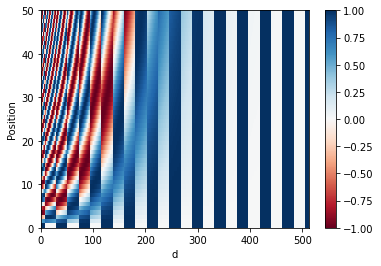

In [739]:
def get_angles(pos, k, d):
    """
    Get the angles for the positional encoding
    
    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        k --   Row vector containing the dimension span [[0, 1, 2, ..., d-1]]
        d(integer) -- Encoding size
    
    Returns:
        angles -- (pos, d) numpy array 
    """
    
    # Get i from dimension span k
    i = k // 2
    # Calculate the angles using pos, i and d
    angles = pos / (10000 ** (2 * i / d))
    
    return angles

def get_positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # Initialize a matrix angle_rads of all the angles 
    angle_rads = get_angles(np.array(range(positions)).reshape(-1, 1),
                            np.array(range(d)).reshape(1, -1),
                            d)
  
    # Apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # Apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    
    return torch.from_numpy(pos_encoding).float()

"""
Test positional encoding
"""
pos_encoding = get_positional_encoding(50, 512)

print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

The encoder that contains positional encoding and several encoder blocks.

In [740]:
class Encoder(nn.Module):
    def __init__(self, emb_dim, num_layers, num_heads, forward_expansion, dropout, max_seq_len, device):
        super().__init__()
        self.device = device
        self.positional_encoding = get_positional_encoding(max_seq_len, emb_dim)
        self.layers = nn.ModuleList([TransformerBlock(emb_dim, num_heads, forward_expansion, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, seqs, embedded, mask, approach = 0):
        batch_size, seq_len = seqs.shape
        embedded = embedded + self.positional_encoding[:, :seq_len, :].to(self.device)
        out = self.dropout(embedded)
        for layer in self.layers:
            out = layer(out, out, out, mask = mask, approach = approach)
        
        return out

One decoder block.

In [741]:
class DecoderBlock(nn.Module):
    def __init__(self, emb_dim, num_heads, forward_expansion, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(emb_dim, num_heads)
        self.norm = nn.LayerNorm(emb_dim)
        self.transformer_block = TransformerBlock(emb_dim, num_heads, forward_expansion, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, embedded_target_seqs, keys, values, source_mask, target_mask, approach = 0):
        attentions = self.attention(embedded_target_seqs, embedded_target_seqs, embedded_target_seqs, mask = target_mask, approach = approach)
        x = self.norm(attentions + embedded_target_seqs)  # Adding skip connection
        queries = self.dropout(x)
        out = self.transformer_block(queries, keys, values, mask = source_mask, approach = approach)

        return out

The decoder that contains positional encoding and several decoder blocks.

In [742]:
class Decoder(nn.Module):
    def __init__(self, emb_dim, num_layers, num_heads, forward_expansion, dropout, max_seq_len, device):
        super().__init__()
        self.device = device
        self.positional_encoding = get_positional_encoding(max_seq_len, emb_dim)
        self.layers = nn.ModuleList([DecoderBlock(emb_dim, num_heads, forward_expansion, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, seqs, embedded, enc_out, source_mask, target_mask, approach = 0):
        batch_size, seq_len = seqs.shape
        embedded = embedded + self.positional_encoding[:, :seq_len, :].to(self.device)
        out = self.dropout(embedded)
        for layer in self.layers:
            out = layer(out, enc_out, enc_out, source_mask, target_mask, approach = approach) 

        return out

The final transformer model. Note that because the inputs and outputs are both in English we use one single vocabulary that contains all words in both the input and output sentences for simplicity. Therefore, we also use the same embedding layer for both the encoder and decoder.

In [743]:
class Transformer(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 pad_idx,
                 emb_dim = 256, 
                 num_layers = 6, 
                 forward_expansion = 4, 
                 num_heads = 8, 
                 dropout = 0.1,
                 device = 'cpu',
                 max_seq_len = 100):
        super().__init__()
        self.device = device
        self.pad_idx = pad_idx
        self.embedder = nn.Embedding(vocab_size, emb_dim)
        self.encoder = Encoder(emb_dim, num_layers, num_heads, forward_expansion, dropout, max_seq_len, device)
        self.decoder = Decoder(emb_dim, num_layers, num_heads, forward_expansion, dropout, max_seq_len, device)
        self.fc_out = nn.Linear(emb_dim, vocab_size)

    def get_source_mask(self, seqs):
        # source_mask: (batch_size, 1, 1, seq_len)
        source_mask = (seqs != self.pad_idx).unsqueeze(1).unsqueeze(2)
        return source_mask.to(self.device)

    def get_target_mask(self, seqs):
        batch_size, seq_len = seqs.shape
        # target_mask: (batch_size, 1, seq_len, seq_len)
        target_mask = torch.tril(torch.ones([seq_len, seq_len])).expand(batch_size, 1, seq_len, seq_len)
        return target_mask.to(self.device)
    
    def forward(self, source_seqs, target_seqs, approach = 0):
        source_mask = self.get_source_mask(source_seqs)
        target_mask = self.get_target_mask(target_seqs)
        source_embedded = self.embedder(source_seqs)
        target_embedded = self.embedder(target_seqs)
        encoded_source_seqs = self.encoder(source_seqs, source_embedded, source_mask, approach)
        out = self.decoder(target_seqs, target_embedded, encoded_source_seqs, source_mask, target_mask, approach)
        out = self.fc_out(out)

        return out

In [744]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [829]:
model = Transformer(preprocessor.num_tokens, 0, 128, device = device, max_seq_len = preprocessor.max_seq_length)


Test the output shape

In [830]:
print(torch.tensor(preprocessor.pad_minibatch(preprocessor.sequences[0][:5])).shape)
print(model(torch.tensor(preprocessor.pad_minibatch(preprocessor.sequences[0][:5])), torch.tensor(preprocessor.pad_minibatch(preprocessor.sequences[1][:5]))).shape)
      

torch.Size([5, 14])
torch.Size([5, 16, 159])


# Train the model

## Write the training loop

In [787]:
################# BUILDING MODEL ###################
import time
from torch.nn.utils.rnn import pad_sequence

def pad_collate(batch):
    (xx, yy) = zip(*batch)

    xx_pad = pad_sequence(xx, batch_first = True, padding_value = 0)
    yy_pad = pad_sequence(yy, batch_first = True, padding_value = 0)

    return xx_pad, yy_pad

def experiment(train_dataset, args):
    model = Transformer(preprocessor.num_tokens, 0, 128, 3, 4, 4, device = device, max_seq_len = preprocessor.max_seq_length)

    print(model)
    
    # ****** Copy model to device ****** #
    model.to(device)

    # ====== Loss function ====== #
    lossfunction = nn.CrossEntropyLoss(reduction = 'sum', ignore_index = 0) 

    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.001)

    # ====== Data collection ====== #
    list_epoch = [] 
    list_train_loss = []
    
    best_loss = 10000

    # ====== Loop ====== #
    for epoch in range(args.epoch):  
        
        t0 = time.time()
        
        # ====== Train ====== #
        model.train() # Set the model be 'train mode' 
        train_loss = 0 # to sum up each batch
        normalization = 0
        
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = args.batch_size, shuffle = True, collate_fn = pad_collate)
        
        for batch_X, batch_y in train_dataloader:
            
            optimizer.zero_grad()

            # ****** Transfer data to device ****** #
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            pred_y = model(batch_X, batch_y[:, :-1])
                        
            loss = lossfunction(pred_y.view(-1, pred_y.shape[-1]), batch_y[:, 1:].contiguous().view(-1))

            loss.backward()
            
            optimizer.step()
            
            train_loss += loss.item()
                                         
            normalization += (batch_y != 0).sum().item()
            
        train_loss = train_loss / normalization
        list_train_loss.append(train_loss)
        list_epoch.append(epoch)
                
        print(f'{time.time() - t0} seconds')
        
        if train_loss < best_loss:
            print(f"Epoch {epoch}: The best loss decreased from {best_loss: .4f} to {train_loss: .4f}")
            best_loss = train_loss
            torch.save(model.state_dict(), './model/model_dict_best.pt')
        else:
            print(f"Epoch {epoch}: The best train loss did not decrease")
        
        print(f'Epoch: {epoch}, Train Loss: {train_loss: .4f}')
        print('~' * 100)
        
    return list_epoch, list_train_loss


## Train

In [788]:
import argparse
import random

In [789]:
parser = argparse.ArgumentParser()

args = parser.parse_args("")

args.epoch = 200
args.batch_size = 5

num_train = len(preprocessor.sequences[0])

train_dataset = S2SDataset(preprocessor.sequences[0], preprocessor.sequences[1])

list_epoch, list_train_loss = experiment(train_dataset, args)


Transformer(
  (embedder): Embedding(159, 128)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadAttention(
          (q_linear): Linear(in_features=32, out_features=32, bias=False)
          (k_linear): Linear(in_features=32, out_features=32, bias=False)
          (v_linear): Linear(in_features=32, out_features=32, bias=False)
          (fc_out): Linear(in_features=128, out_features=128, bias=True)
        )
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerBlock(
        (attention): MultiHeadAttention(
          (q_linear): Linear(in_features=32, out_features

Epoch: 7, Train Loss:  3.3611
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.1924450397491455 seconds
Epoch 8: The best loss decreased from  3.3611 to  3.1417
Epoch: 8, Train Loss:  3.1417
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.18451285362243652 seconds
Epoch 9: The best loss decreased from  3.1417 to  2.9063
Epoch: 9, Train Loss:  2.9063
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.186614990234375 seconds
Epoch 10: The best loss decreased from  2.9063 to  2.8251
Epoch: 10, Train Loss:  2.8251
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.21060824394226074 seconds
Epoch 11: The best loss decreased from  2.8251 to  2.5341
Epoch: 11, Train Loss:  2.5341
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.21

0.20883798599243164 seconds
Epoch 46: The best loss decreased from  0.2979 to  0.2658
Epoch: 46, Train Loss:  0.2658
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.1955409049987793 seconds
Epoch 47: The best loss decreased from  0.2658 to  0.2650
Epoch: 47, Train Loss:  0.2650
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.19533586502075195 seconds
Epoch 48: The best loss decreased from  0.2650 to  0.2480
Epoch: 48, Train Loss:  0.2480
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.19196319580078125 seconds
Epoch 49: The best train loss did not decrease
Epoch: 49, Train Loss:  0.2644
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.19572210311889648 seconds
Epoch 50: The best loss decreased from  0.2480 to  0.2328
Epoch: 50, Train Loss:  0.2328
~~~~~~~~~~~~~~~~~~~~~~~

0.19643497467041016 seconds
Epoch 86: The best train loss did not decrease
Epoch: 86, Train Loss:  0.0728
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.18559908866882324 seconds
Epoch 87: The best loss decreased from  0.0703 to  0.0692
Epoch: 87, Train Loss:  0.0692
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.19877409934997559 seconds
Epoch 88: The best loss decreased from  0.0692 to  0.0494
Epoch: 88, Train Loss:  0.0494
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.18838906288146973 seconds
Epoch 89: The best train loss did not decrease
Epoch: 89, Train Loss:  0.0634
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.19220685958862305 seconds
Epoch 90: The best train loss did not decrease
Epoch: 90, Train Loss:  0.0503
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

0.21694183349609375 seconds
Epoch 125: The best train loss did not decrease
Epoch: 125, Train Loss:  0.0322
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.2293081283569336 seconds
Epoch 126: The best train loss did not decrease
Epoch: 126, Train Loss:  0.0308
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.19786691665649414 seconds
Epoch 127: The best train loss did not decrease
Epoch: 127, Train Loss:  0.0346
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.1996150016784668 seconds
Epoch 128: The best loss decreased from  0.0283 to  0.0259
Epoch: 128, Train Loss:  0.0259
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.20433902740478516 seconds
Epoch 129: The best loss decreased from  0.0259 to  0.0224
Epoch: 129, Train Loss:  0.0224
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

0.2010331153869629 seconds
Epoch 165: The best train loss did not decrease
Epoch: 165, Train Loss:  0.0161
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.20267891883850098 seconds
Epoch 166: The best train loss did not decrease
Epoch: 166, Train Loss:  0.0246
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.20230603218078613 seconds
Epoch 167: The best train loss did not decrease
Epoch: 167, Train Loss:  0.0202
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.2063608169555664 seconds
Epoch 168: The best train loss did not decrease
Epoch: 168, Train Loss:  0.0151
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.20043015480041504 seconds
Epoch 169: The best train loss did not decrease
Epoch: 169, Train Loss:  0.0151
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## Display the training history

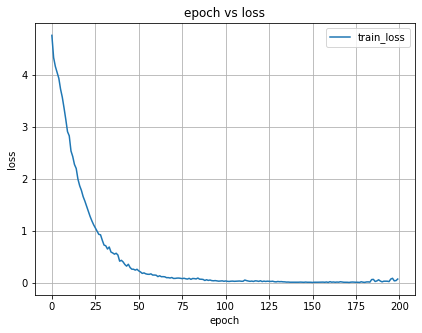

In [790]:
fig = plt.figure(figsize=(15,5))

# ====== Plot Loss ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

plt.show()


# Chat

In [831]:
from torch.distributions.categorical import Categorical

In [832]:
model = Transformer(preprocessor.num_tokens, 0, 128, 3, 4, 4, device = device, max_seq_len = preprocessor.max_seq_length)
model.load_state_dict(torch.load('./model/model_dict_best.pt'))

<All keys matched successfully>

In [833]:
def predict_sequence(input_seq, model, SOS_idx, EOS_idx, PAD_idx, max_seq_len, method = 0):
    '''
            This function is used to generate a output sequence self-recursively according to 
        an input sequence.
    '''
    model.eval()
    model.to(device)
    input_mask = (input_seq != PAD_idx).unsqueeze(1).unsqueeze(2).to(device)  # Make input mask
    input_embedded = model.embedder(input_seq)
    encoding = model.encoder(input_seq, input_embedded, input_mask)  # Encoder the input
    decoder_input = torch.LongTensor([[SOS_idx]]).to(device)  # Use SOS token to initiate the decoder
    
    # Continue obtaining the next decoder token until decoder outputs an EOS token or it reaches max_len 
    for pos in range(max_seq_len):
        # Make target mask, pos + 1 cause pos starts at 0
        decoder_input_mask = (torch.triu(torch.ones((1, 1, pos + 1, pos + 1)), diagonal = 1) == 0).to(device) 
        
        decoder_input_embedded = model.embedder(decoder_input)

        out = model.fc_out(model.decoder(decoder_input, decoder_input_embedded, encoding, input_mask, decoder_input_mask))

        probs = torch.softmax(out, dim = -1) 
        if method == 0:
            action = torch.argmax(probs[:, -1]).unsqueeze(0).unsqueeze(0)
        else:
            # probs is a categorical probability distribution over the output vocab
            distr = Categorical(probs = probs)
            action = distr.sample()[:, -1].unsqueeze(0) # sample from that distribution to get next token

        # Concatenate that token to our running list of output tokens 
        decoder_input = torch.cat((decoder_input, action), dim = 1) 
        # If the model outputs an EOS token, it is terminated
        if action == EOS_idx:
            # [0] because we assume batch size of 1 
            # [1: -1] excludes the start and end token from the output string 
            de_str = decoder_input[0][1: -1]
            return de_str
        
    de_str = decoder_input[0][1:]
    return de_str


See how the model predicts the training data.

In [860]:
for i in range(len(preprocessor.sequences[0])):

    input_seq = torch.tensor([preprocessor.sequences[0][i]], dtype = torch.int64).to(device)

    outputs = predict_sequence(input_seq, model, 1, 2, 0, 10)

    print('\n')

    print(f"[{' '.join([preprocessor.idx2word[token] for token in preprocessor.sequences[0][i][1:-1]])}]")
    print(f"True: {' '.join([preprocessor.idx2word[token] for token in preprocessor.sequences[1][i][1:-1]])}")
    print(f"Pred: {' '.join([preprocessor.idx2word[token] for token in outputs.numpy().tolist()])}")




[hello i am jiayu what is your name]
True: i am dennis nice to meet you
Pred: i am dennis nice to meet you


[how was the party yesterday]
True: it was super nice everybody had fun
Pred: it was super nice everybody had fun


[when do you usually go to the office in the morning]
True: i usually go to the office at 9 but i was late this morning
Pred: i usually go to the office at 9 but i


[do you want to meet in the campus at 10 pm tonight]
True: okay that sounds good i will meet you there tonight
Pred: okay that sounds good i will meet you there tonight


[does this sunday works for everyone]
True: yes it works perferct for me
Pred: yes it works perferct for me


[what is your favourite book of all time]
True: three body problem i love it so much and i have read it twice
Pred: three body problem i love it so much and i


[what do you love doing for fun at spare time]
True: i play soccer and go hiking and i sometimes go swimming too
Pred: i play soccer and go hiking and i sometimes go

Try to chat with the chatbot.

In [861]:
input_sentences = [["Hey, I'm lucy!"], ["what have you been up to?"], ["let's meet at 10"]]

input_cleaned = preprocessor.cleanse_corpus(input_sentences)

input_seqs = preprocessor.get_sequences_of_test_texts(input_cleaned)

for i in range(len(input_seqs)):
    input_seq = [input_seqs[i]]
    
    input_seq = torch.tensor(input_seq, dtype = torch.int64).to(device)

    output_seq = predict_sequence(input_seq, model, 1, 2, 0, 20).numpy()

    words = []
    for idx in output_seq:
        words.append(preprocessor.idx2word[idx])
    output_sentence = " ".join(words)

    print(f"You: {input_sentences[i][0]}")
    print(f"Bot: {output_sentence}")
    print('\n')

You: Hey, I'm lucy!
Bot: i am dennis nice to meet you


You: what have you been up to?
Bot: i have been going to graduate school


You: let's meet at 10
Bot: okay that sounds good i will meet you there tonight


